# Embed, Encode, Attend, Predict (EEAP)

Keras之文本分类实现https://zhuanlan.zhihu.com/p/29201491
    
https://github.com/sujitpal/eeap-examples

# Data Analysis

In [1]:
from __future__ import division, print_function
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import collections
import nltk
import numpy as np
import os
import logging
%matplotlib inline

In [24]:
DATA_DIR = "../../data_origin/nlp/"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")

logging.basicConfig()

## Data Loading

We make use of built in downloader available in Scikit-Learn to download the 20 newsgroup dataset from [http://people.csail.mit.edu/jrennie/20Newsgroups/20news-bydate.tar.gz](http://people.csail.mit.edu/jrennie/20Newsgroups/20news-bydate.tar.gz) and make it available in an in-memory data structure.

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [39]:
ng_data.target

array([10,  3, 17, ...,  3,  1,  7])

In [ ]:
=================   ==========
Classes                     20
Samples total            18846
Dimensionality               1
Features                  text
=================   ==========

In [20]:
type(ng_data)

sklearn.utils.Bunch

In [8]:
ng_data.data[:2]

["From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu>\nSubject: Pens fans reactions\nOrganization: Post Office, Carnegie Mellon, Pittsburgh, PA\nLines: 12\nNNTP-Posting-Host: po4.andrew.cmu.edu\n\n\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)\nSubject: Which h

In [6]:
texts = ng_data.data
y = np.array(ng_data.target)
id2labels = {x[0]:x[1] for x in enumerate(ng_data.target_names)}

## Vocabulary

In [36]:
counter = collections.Counter()
for text in ng_data.data:
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            counter[word] += 1



AttributeError: 'bytes' object has no attribute 'format'

In [37]:
fvocab = open(VOCAB_FILE, "wb")
for word, count in counter.most_common():
    fvocab.write("{:s}\t{:d}\n".format(word, count).encode())
fvocab.close()

In [38]:
vocab_size = len([w for w, c in counter.most_common() if c >= 5])
print(vocab_size)

46605


## Compute #-sentences per document

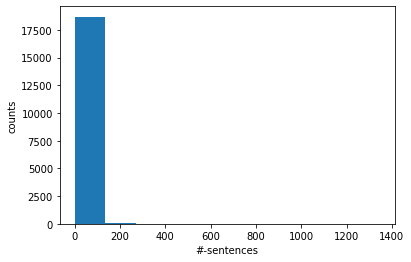

In [9]:
num_sents = np.zeros(num_docs)
for i, text in enumerate(ng_data.data):
    for sent in nltk.sent_tokenize(text):
        num_sents[i] += 1

plt.hist(num_sents, bins=10)
plt.xlabel("#-sentences")
plt.ylabel("counts")
plt.show()

In [14]:
import pandas as pd

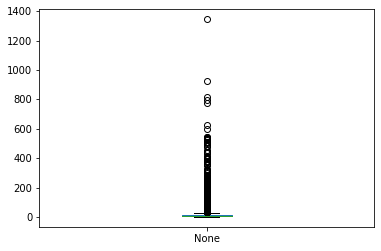

In [15]:
pd.Series(num_sents).plot(kind='box')

In [12]:
num_sents.max()

1345.0

In [13]:
for i in range(90, 100):
    print("{:d} percentile, #-sentences: {:.0f}".format(
        i, np.percentile(num_sents, i)))

90 percentile, #-sentences: 28
91 percentile, #-sentences: 30
92 percentile, #-sentences: 32
93 percentile, #-sentences: 35
94 percentile, #-sentences: 38
95 percentile, #-sentences: 43
96 percentile, #-sentences: 49
97 percentile, #-sentences: 58
98 percentile, #-sentences: 75
99 percentile, #-sentences: 113


句子数量的99%分位数是 113，即99%的文章包含的句子数目小于等于113

## Compute #-words per sentence

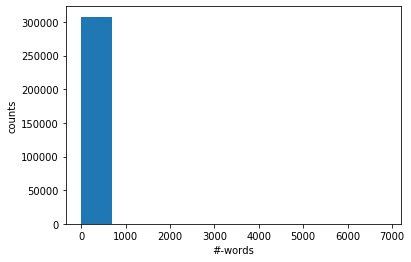

In [16]:
num_words = []
for i, text in enumerate(ng_data.data):
    for sent in nltk.sent_tokenize(text):
        num_words_in_sent = 0
        for word in nltk.word_tokenize(sent):
            num_words_in_sent += 1
        num_words.append(num_words_in_sent)

plt.hist(num_words, bins=10)
plt.xlabel("#-words")
plt.ylabel("counts")
plt.show()

In [17]:
num_words = np.array(num_words)
for i in range(90, 100):
    print("{:d} percentile, #-sentences: {:.0f}".format(
        i, np.percentile(num_words, i)))

90 percentile, #-sentences: 47
91 percentile, #-sentences: 49
92 percentile, #-sentences: 52
93 percentile, #-sentences: 56
94 percentile, #-sentences: 60
95 percentile, #-sentences: 64
96 percentile, #-sentences: 70
97 percentile, #-sentences: 79
98 percentile, #-sentences: 92
99 percentile, #-sentences: 119


句子长度的99%分位数是 119，即99%的句子长度小于等于119

# Baseline

Attempt to run the classification task using "traditional" pipeline.

In [21]:
from __future__ import division, print_function
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
import logging
%matplotlib inline

In [25]:
# DATA_DIR = "../data"

VOCAB_SIZE = 40000
NUM_CLASSES = 20

logging.basicConfig()

## Data Generation

In [26]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [27]:
cvec = CountVectorizer(max_features=VOCAB_SIZE)
tfidf = TfidfTransformer()
Xc = cvec.fit_transform(ng_data.data)
X = tfidf.fit_transform(Xc)
y = np.array(ng_data.target)
print(X.shape, y.shape)

(18846, 40000) (18846,)


In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7, random_state=14)
print(Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape)

(13192, 40000) (13192,) (5654, 40000) (5654,)


## Naive Bayes Classifier

In [33]:
clf = MultinomialNB()
clf.fit(Xtrain, ytrain)
ytest_ = clf.predict(Xtest)
print("accuracy: {:.3f}".format(accuracy_score(ytest, ytest_)))

accuracy: 0.854


## Support Vector Machine Classifier

In [34]:
clf = SGDClassifier()
clf.fit(Xtrain, ytrain)
ytest_ = clf.predict(Xtest)
print("accuracy: {:.3f}".format(accuracy_score(ytest, ytest_)))

accuracy: 0.914


# Embed and Predict (BoW)

We treat each document as a Bag of Words (BoW), and just average the GloVe word embeddings to create document vectors, and run them through a 2 layer classifier network.

In [54]:
import tensorflow as tf

In [52]:
from __future__ import division, print_function
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
import numpy as np
import logging
import os
%matplotlib inline

In [40]:
GLOVE_DIR = '../../../Documents/nlpdata/'

In [41]:
# DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(GLOVE_DIR, "glove.840B.300d.txt")
WORD_EMBED_SIZE = 300

NUM_CLASSES = 20
BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [43]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.decode().strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40683


## Load GloVe embeddings

In [46]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.decode().strip().split(" ")
    word = cols[0]
    if word not in word2id:
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40683, 300)


## Compute Document Vectors

In [47]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [48]:
D = np.zeros((num_docs, WORD_EMBED_SIZE))
for i, text in enumerate(ng_data.data):
    doc_vec = np.zeros(WORD_EMBED_SIZE)
    num_words = 0
    for sent in nltk.sent_tokenize(text):
        sent = sent.encode("utf8").decode("ascii", "ignore").lower()
        for word in nltk.word_tokenize(sent):
            try:
                doc_vec += E[word2id[word]]
            except KeyError:
                doc_vec += E[word2id["UNK"]]
            num_words += 1
    doc_vec /= num_words
    D[i] = doc_vec
print(D.shape)

(18846, 300)


## Data Generation

In [49]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [50]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(D, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 300) (13192, 20) (5654, 300) (5654, 20)


## Define Network

In [55]:
inputs = Input(shape=(WORD_EMBED_SIZE, ))
fc1 = Dense(100, activation="relu")(inputs)
fc1_dropout = Dropout(0.2)(fc1)
fc2 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc2)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc1_dropout)

In [56]:
model = Model(inputs=inputs, outputs=outputs)

In [57]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
             metrics=["accuracy"])

In [58]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                2020      
Total params: 32,120
Trainable params: 32,120
Non-trainable params: 0
_________________________________________________________________


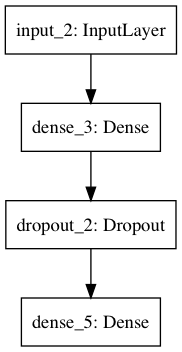

In [59]:
tf.keras.utils.plot_model(model)

## Train Network

In [60]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, validation_split=0.1)

Epoch 1/10
186/186 [==============================] - 0s 2ms/step - loss: 2.6591 - accuracy: 0.2524 - val_loss: 2.2534 - val_accuracy: 0.4470
Epoch 2/10
186/186 [==============================] - 0s 2ms/step - loss: 1.9637 - accuracy: 0.4562 - val_loss: 1.6873 - val_accuracy: 0.5621
Epoch 3/10
186/186 [==============================] - 0s 2ms/step - loss: 1.5879 - accuracy: 0.5323 - val_loss: 1.4073 - val_accuracy: 0.5985
Epoch 4/10
186/186 [==============================] - 0s 2ms/step - loss: 1.3759 - accuracy: 0.5856 - val_loss: 1.2565 - val_accuracy: 0.6303
Epoch 5/10
186/186 [==============================] - 0s 2ms/step - loss: 1.2473 - accuracy: 0.6228 - val_loss: 1.1426 - val_accuracy: 0.6674
Epoch 6/10
186/186 [==============================] - 0s 2ms/step - loss: 1.1524 - accuracy: 0.6412 - val_loss: 1.0696 - val_accuracy: 0.6833
Epoch 7/10
186/186 [==============================] - 0s 2ms/step - loss: 1.0885 - accuracy: 0.6584 - val_loss: 1.0193 - val_accuracy: 0.6992
Epoch 

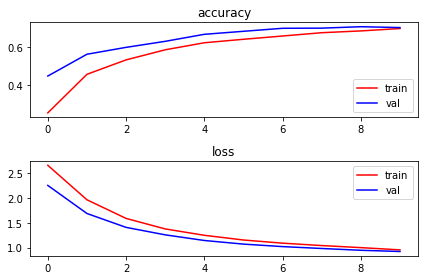

In [64]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["accuracy"], color="r", label="train")
plt.plot(history.history["val_accuracy"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [65]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.718

confusion matrix

[[129   0   0   0   0   0   0   1   5   1   0   2   1   4   8  40   8  19  16   0]
 [  0 198  24   1   7  15   4   0   1   1   0   2   8   3  12   0   1   1   0   0]
 [  2  31 185  16  18  27   8   1   1   1   0   4   4   0   1   0   0   0   0   0]
 [  0  17  33 145  56  13  20   2   1   0   0   2  24   0   2   0   0   0   0   0]
 [  0  21  17  15 162   7  22   2   1   0   0   2  19   1   7   0   0   1   0   0]
 [  0  41  23   4   3 184   6   0   1   1   1   1   1   3   3   0   0   0   1   0]
 [  0   1   4   3   7   1 233  20   8   1   4   3   8   0   3   1   0   0   2   0]
 [  2   0   1   0   0   0   5 242  22   0   0   0  12   2   1   1   5   0   2   0]
 [  1   0   0   0   0   0  10  26 245   1   1   0   9   0   1   1   9   1   3   0]
 [  2   2   1   0   0   1   3   0   3 283  14   0   0   2   1   3   0   0   0   0]
 [  3   0   0   0   0   1   0   0   2  19 241   1   1   0   1   0   0   1   1   0]
 [  1  10   4   0   2   3   1   0   0   0   0 

# Embed, Encode and Predict

In [67]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

In [70]:
# DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(GLOVE_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [68]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [71]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [72]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [73]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

__Note:__ 

Setting the embedding weights and making the layer trainable (so backprop can update the weights) results in much better performance (0.788 accuracy on test set, 0.9831 on training set) than making the layer non-trainable (0.706 accuracy on test set, 0.7827 on training set). One possible reason is that making the embedding layer non-trainable drops the number of trainable parameters from 12,540,970 to 321,970 (about 10x our base embed-predict BoW model with 32,120 parameters).

In [74]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")
sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE))(sent_emb)

sent_encoder = Model(inputs=sent_inputs, outputs=sent_enc)
sent_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 60, 300)           12204900  
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               241200    
Total params: 12,446,100
Trainable params: 12,446,100
Non-trainable params: 0
_________________________________________________________________


In [75]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")
doc_emb = TimeDistributed(sent_encoder)(doc_inputs)
doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE))(doc_emb)

fc1_dropout = Dropout(0.2)(doc_enc)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
outputs = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40, 60)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 200)           12446100  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               75600     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 20)                1020

In [76]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

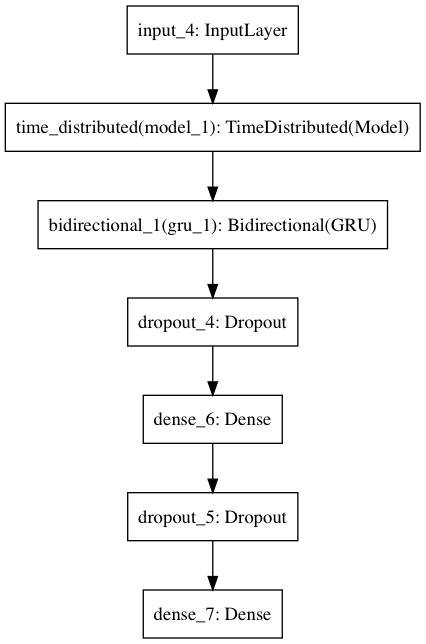

In [77]:
tf.keras.utils.plot_model(model)

In [78]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=1, validation_split=0.1)

186/186 [==============================] - 985s 5s/step - loss: 2.9340 - accuracy: 0.0809 - val_loss: 2.6213 - val_accuracy: 0.1432


In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 127s - loss: 2.9953 - acc: 0.0572 - val_loss: 2.9256 - val_acc: 0.0902
Epoch 2/10
11872/11872 [==============================] - 127s - loss: 2.4206 - acc: 0.1880 - val_loss: 1.7549 - val_acc: 0.4205
Epoch 3/10
11872/11872 [==============================] - 127s - loss: 1.5096 - acc: 0.4501 - val_loss: 1.2033 - val_acc: 0.5697
Epoch 4/10
11872/11872 [==============================] - 128s - loss: 0.9024 - acc: 0.6685 - val_loss: 1.0022 - val_acc: 0.6705
Epoch 5/10
11872/11872 [==============================] - 125s - loss: 0.5487 - acc: 0.8038 - val_loss: 1.0231 - val_acc: 0.6970
Epoch 6/10
11872/11872 [==============================] - 127s - loss: 0.3494 - acc: 0.8825 - val_loss: 1.0686 - val_acc: 0.7326
Epoch 7/10
11872/11872 [==============================] - 127s - loss: 0.2280 - acc: 0.9332 - val_loss: 1.1956 - val_acc: 0.7417
Epoch 8/10
11872/11872 [========================

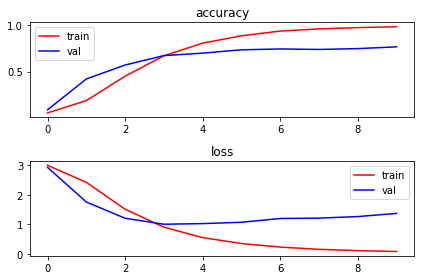

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.770

confusion matrix

[[183   0   0   0   0   0   0   1   0   1   0   1   0   2   1  12   0   4   3  17]
 [  0 214  28   8   3  11   3   1   0   0   0   4   9   4   9   0   0   0   1   0]
 [  0  38 214  19   6  29   0   4   1   0   0   1   2   1   2   0   0   0   0   2]
 [  0  15  38 204  17   0   8   3   0   0   1   2   6   1   0   0   0   0   0   0]
 [  0   9  22  40 163   2  12  10   1   0   0   0  18   0   0   0   0   0   2   0]
 [  0  17  28   4   2 234   1   0   0   0   0   9   5   0   2   0   0   0   0   0]
 [  0   1   0  33  16   0 188  28   8   2   2   1   5   2   2   1   0   1   0   0]
 [  0   1   0   0   6   0   6 216   8   0   0   0  10   0   7   0   0   0   3   2]
 [  0   0   0   1   1   0   0  21 248   2   0   0   2   0   7   0   2   0  10   0]
 [  1   1   1   0   0   0   2   2  19 273  23   0   0   3   4   0   8   1   3   1]
 [  1   1   1   1   0   0   4   3   1  15 281   0   1   0   0   0   0   0   1   0]
 [  0   9   1   1   1   7   0   2   0   2   0 

# Embed, Encode, Attend and Predict

In [79]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

In [2]:
# DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

### Sentence Level

In [86]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")
sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)

sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                            return_sequences=True))(sent_emb)

sent_att = custom_attn.AttentionM()(sent_enc)

sent_model = Model(inputs=sent_inputs, outputs=sent_att)
sent_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 60, 300)           12204900  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 60, 200)           241200    
_________________________________________________________________
attention_m (AttentionM)     (None, 200)               260       
Total params: 12,446,360
Trainable params: 12,446,360
Non-trainable params: 0
_________________________________________________________________


In [87]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb = TimeDistributed(sent_model)(doc_inputs)

doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE,
                           return_sequences=True))(doc_emb)

# doc_att = custom_attn.AttentionM()(doc_enc)
doc_att = AttentionM()(doc_enc)

fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=doc_pred)
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 40, 60)]          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 200)           12446360  
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40, 100)           75600     
_________________________________________________________________
attention_m_1 (AttentionM)   (None, 100)               140       
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0   

In [88]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

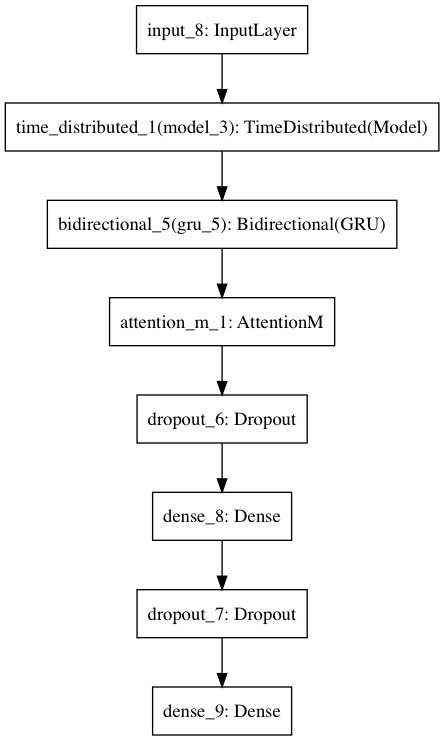

In [89]:
tf.keras.utils.plot_model(model)

In [90]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=1, validation_split=0.1)

186/186 [==============================] - 889s 5s/step - loss: 2.9666 - accuracy: 0.0698 - val_loss: 2.7228 - val_accuracy: 0.1189


In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 140s - loss: 2.9606 - acc: 0.0784 - val_loss: 2.6775 - val_acc: 0.1235
Epoch 2/10
11872/11872 [==============================] - 137s - loss: 2.1478 - acc: 0.2532 - val_loss: 1.4592 - val_acc: 0.5386
Epoch 3/10
11872/11872 [==============================] - 139s - loss: 1.1226 - acc: 0.6060 - val_loss: 0.8516 - val_acc: 0.7386
Epoch 4/10
11872/11872 [==============================] - 139s - loss: 0.5574 - acc: 0.8210 - val_loss: 0.7516 - val_acc: 0.7765
Epoch 5/10
11872/11872 [==============================] - 139s - loss: 0.2927 - acc: 0.9130 - val_loss: 0.7602 - val_acc: 0.7894
Epoch 6/10
11872/11872 [==============================] - 138s - loss: 0.1517 - acc: 0.9586 - val_loss: 0.8532 - val_acc: 0.7932
Epoch 7/10
11872/11872 [==============================] - 137s - loss: 0.0917 - acc: 0.9773 - val_loss: 0.9222 - val_acc: 0.7932
Epoch 8/10
11872/11872 [========================

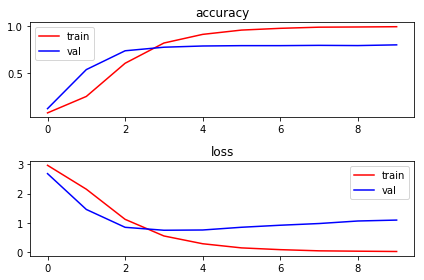

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.824

confusion matrix

[[196   1   0   0   0   0   0   0   0   1   0   1   0   0   0   2   0   2   9  34]
 [  1 220  13   4   2  15   4   0   0   1   0   1   7   0   4   1   3   2   4   0]
 [  1   8 239  15  10  24   0   0   2   3   2   2   3   0   2   0   0   0   0   1]
 [  0  12  26 208  23   3   9   2   0   0   1   1  17   1   0   0   1   0   0   0]
 [  0   8   7  28 190   1   4   2   1   1   0   4  20   4   1   0   0   0   1   0]
 [  1  16  17   4   2 245   0   0   0   1   1   2   1   1   3   0   0   0   0   0]
 [  0   6   5  13   6   0 203   8   6   1   2   0  12   1   2   2   1   1   3   0]
 [  0   2   2   0   1   0   9 235  14   0   2   0   6   1   7   2   2   0   2   0]
 [  4   1   0   0   0   0   1   4 268   0   1   0   0   0  15   0   1   0   2   1]
 [  0   0   2   1   0   0   0   1   1 267  18   0   0   1   2   2   7   0   2   0]
 [  0   0   0   0   0   0   3   2   1  25 253   0   1   0   1   0   1   0   1   0]
 [  1   7   6   0   2   1   0   0   1   1   0 

# Embed, Encode, Attend and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalAveragePooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

### Sentence Level

In [94]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     mask_zero=True,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                             return_sequences=True))(sent_emb)

sent_att = custom_attn.AttentionMC()(sent_enc)

sent_model = Model(inputs=sent_inputs, outputs=sent_att)

# sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
#                              return_sequences=False))(sent_emb)

# sent_model = Model(inputs=sent_inputs, outputs=sent_enc)

sent_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 60)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 60, 300)           12204900  
_________________________________________________________________
bidirectional_7 (Bidirection (None, 60, 200)           241200    
_________________________________________________________________
attention_mc (AttentionMC)   (None, 200)               3860      
Total params: 12,449,960
Trainable params: 12,449,960
Non-trainable params: 0
_________________________________________________________________


In [95]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb = TimeDistributed(sent_model)(doc_inputs)

doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE,
                            return_sequences=True))(doc_emb)

# doc_att = custom_attn.AttentionMC()(doc_enc)
doc_att = AttentionMC()(doc_enc)

fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=doc_pred)
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 40, 60)]          0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 40, 200)           12449960  
_________________________________________________________________
bidirectional_8 (Bidirection (None, 40, 100)           75600     
_________________________________________________________________
attention_mc_1 (AttentionMC) (None, 100)               1740      
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0   

In [96]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

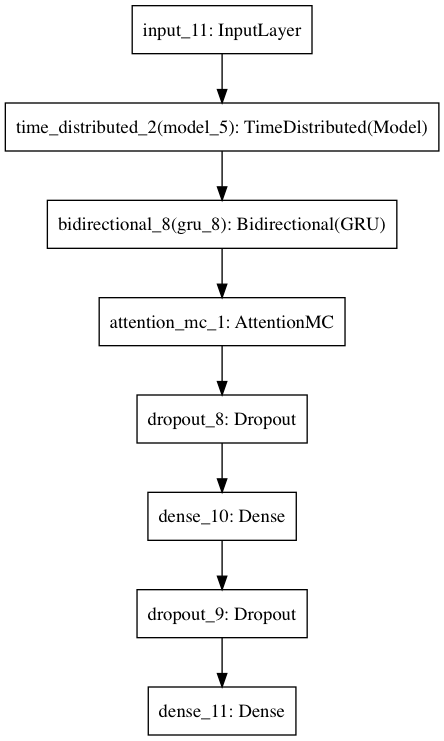

In [97]:
tf.keras.utils.plot_model(model)

In [98]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=1, validation_split=0.1)

186/186 [==============================] - 985s 5s/step - loss: 2.5071 - accuracy: 0.1920 - val_loss: 1.6809 - val_accuracy: 0.4530


In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 258s - loss: 2.4765 - acc: 0.1875 - val_loss: 1.6304 - val_acc: 0.4371
Epoch 2/10
11872/11872 [==============================] - 255s - loss: 1.3235 - acc: 0.5241 - val_loss: 0.9788 - val_acc: 0.6735
Epoch 3/10
11872/11872 [==============================] - 254s - loss: 0.6980 - acc: 0.7645 - val_loss: 0.7566 - val_acc: 0.7538
Epoch 4/10
11872/11872 [==============================] - 254s - loss: 0.3642 - acc: 0.8875 - val_loss: 0.7289 - val_acc: 0.7826
Epoch 5/10
11872/11872 [==============================] - 254s - loss: 0.1867 - acc: 0.9489 - val_loss: 0.7937 - val_acc: 0.7902
Epoch 6/10
11872/11872 [==============================] - 254s - loss: 0.1108 - acc: 0.9709 - val_loss: 0.8700 - val_acc: 0.7909
Epoch 7/10
11872/11872 [==============================] - 254s - loss: 0.0626 - acc: 0.9845 - val_loss: 0.9153 - val_acc: 0.8076
Epoch 8/10
11872/11872 [========================

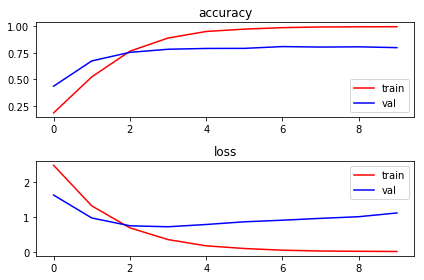

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.807

confusion matrix

[[193   0   0   0   0   0   0   0   0   0   1   7   0   3   1  18   0   9   3   9]
 [  0 226  10   6  17  24   6   1   0   1   1   0   1   3   4   1   0   0   2   0]
 [  0  19 206  27   6  20   0   3   2   1   5   1   0   1   0   1   0   1   1   0]
 [  0  10  18 195  30   8   7   1   0   0   0   1   7   0   1   0   0   0   0   1]
 [  0   9   4  31 218   3   7   0   1   0   0   5   7   4   0   0   0   0   0   0]
 [  1  17  21   3   1 256   2   1   0   2   0   2   2   1   2   3   0   0   0   0]
 [  1   5   3  24  10   1 201   7  11   7   7   0  10   2   0   1   0   1   1   1]
 [  0   1   4   1   3   0   4 230  18   3   5   0  12   1   0   1   0   0   5   0]
 [  1   0   0   2   0   0   3   3 250   2   1   1   2   5   0   0   0   0   5   1]
 [  0   0   2   0   0   1   3   1   3 250  42   0   0   1   1   1   0   4   7   2]
 [  1   0   2   0   0   0   4   1   2   6 294   1   0   0   1   1   0   0   2   0]
 [  4   0   1   1   3   4   0   0   0   1   0 

# Embed, Encode, Attend and Predict

In [1]:
from __future__ import division, print_function
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.layers.pooling import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.models import Model
from keras.optimizers import SGD
from keras.utils import to_categorical
from sklearn.datasets import fetch_20newsgroups
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import custom_attn
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_DIR = "../data"

VOCAB_FILE = os.path.join(DATA_DIR, "ng-vocab.tsv")
MIN_OCCURS = 5

GLOVE_FILE = os.path.join(DATA_DIR, "glove.840B.300d.txt")

# covers about 95% of input data
MAX_SENTS = 40 # maximum number of sentences per document
MAX_WORDS = 60 # maximum number of words per sentence

WORD_EMBED_SIZE = 300
SENT_EMBED_SIZE = 100
DOC_EMBED_SIZE = 50
NUM_CLASSES = 20

BATCH_SIZE = 64
NUM_EPOCHS = 10

logging.basicConfig()

## Load Vocabulary

In [3]:
word2id = {"PAD": 0, "UNK": 1}
fvocab = open(VOCAB_FILE, "rb")
for i, line in enumerate(fvocab):
    word, count = line.strip().split("\t")
    if int(count) <= MIN_OCCURS:
        break
    word2id[word] = i
fvocab.close()
id2word = {v:k for k, v in word2id.items()}
vocab_size = len(word2id)
print("vocab_size: {:d}".format(vocab_size))

vocab_size: 40730


## Load GloVe Embeddings

In [4]:
E = np.zeros((vocab_size, WORD_EMBED_SIZE))
E[1] = np.random.random(WORD_EMBED_SIZE)
fglove = open(GLOVE_FILE, "rb")
for line in fglove:
    cols = line.strip().split(" ")
    word = cols[0]
    if not word2id.has_key(word):
        continue
    vec = np.array([float(x) for x in cols[1:]])
    idx = word2id[word]
    E[idx] = vec
fglove.close()
print(E.shape)

(40730, 300)


## Compute Document Vectors

In [5]:
ng_data = fetch_20newsgroups(subset='all',
                             data_home=DATA_DIR,
                             shuffle=True, 
                             random_state=42)
num_docs = len(ng_data.data)
print(num_docs)

18846


In [6]:
def pad_or_truncate(xs, maxlen):
    if len(xs) > maxlen:
        xs = xs[len(xs) - maxlen:]
    elif len(xs) < maxlen:
        xs = ["PAD"] * (maxlen - len(xs)) + xs
    return xs

xs = ["The", "cat", "fought", "like", "a", "mouse"]
print(pad_or_truncate(xs, 3))
print(pad_or_truncate(xs, 7))

['like', 'a', 'mouse']
['PAD', 'The', 'cat', 'fought', 'like', 'a', 'mouse']


In [7]:
X = np.zeros((num_docs, MAX_SENTS, MAX_WORDS))
for docid in range(num_docs):
    text = ng_data.data[docid]
    sents = pad_or_truncate(nltk.sent_tokenize(text), MAX_SENTS)
    for sid, sent in enumerate(sents):
        words = nltk.word_tokenize(sent)
        words = pad_or_truncate(words, MAX_WORDS)
        for wid, word in enumerate(words):
            try:
                word_id = word2id[word]
            except KeyError:
                word_id = word2id["UNK"]
            X[docid, sid, wid] = word_id
print(X.shape)

(18846, 40, 60)


In [8]:
y = ng_data.target
Y = to_categorical(y, num_classes=NUM_CLASSES)
print(Y.shape)

(18846, 20)


In [9]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size=0.7)
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(13192, 40, 60) (13192, 20) (5654, 40, 60) (5654, 20)


## Define Network

### Sentence Level

In [10]:
sent_inputs = Input(shape=(MAX_WORDS,), dtype="int32")

sent_emb = Embedding(input_dim=vocab_size,
                     output_dim=WORD_EMBED_SIZE,
                     weights=[E])(sent_inputs)
sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
                             return_sequences=True))(sent_emb)

sent_vec = GlobalMaxPooling1D()(sent_enc)
sent_att = custom_attn.AttentionMV()([sent_enc, sent_vec])

sent_model = Model(inputs=sent_inputs, outputs=sent_att)

# sent_enc = Bidirectional(GRU(SENT_EMBED_SIZE,
#                              return_sequences=False))(sent_emb)

# sent_model = Model(inputs=sent_inputs, outputs=sent_enc)

sent_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 60)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 60, 300)       12219000    input_1[0][0]                    
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 60, 200)       240600      embedding_1[0][0]                
____________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalMa (None, 200)           0           bidirectional_1[0][0]            
___________________________________________________________________________________________

In [11]:
doc_inputs = Input(shape=(MAX_SENTS, MAX_WORDS), dtype="int32")

doc_emb = TimeDistributed(sent_model)(doc_inputs)

doc_enc = Bidirectional(GRU(DOC_EMBED_SIZE,
                            return_sequences=True))(doc_emb)

doc_vec = GlobalMaxPooling1D()(doc_enc)
doc_att = custom_attn.AttentionMV()([doc_enc, doc_vec])

fc1_dropout = Dropout(0.2)(doc_att)
fc1 = Dense(50, activation="relu")(fc1_dropout)
fc2_dropout = Dropout(0.2)(fc1)
doc_pred = Dense(NUM_CLASSES, activation="softmax")(fc2_dropout)

model = Model(inputs=doc_inputs, outputs=doc_pred)
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 40, 60)        0                                            
____________________________________________________________________________________________________
time_distributed_1 (TimeDistribu (None, 40, 200)       12471860    input_2[0][0]                    
____________________________________________________________________________________________________
bidirectional_2 (Bidirectional)  (None, 40, 100)       75300       time_distributed_1[0][0]         
____________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalMa (None, 100)           0           bidirectional_2[0][0]            
___________________________________________________________________________________________

In [12]:
model.compile(optimizer="adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

In [13]:
history = model.fit(Xtrain, Ytrain, batch_size=BATCH_SIZE,
                   epochs=NUM_EPOCHS, validation_split=0.1)

Train on 11872 samples, validate on 1320 samples
Epoch 1/10
11872/11872 [==============================] - 143s - loss: 2.6603 - acc: 0.1515 - val_loss: 1.7490 - val_acc: 0.4455
Epoch 2/10
11872/11872 [==============================] - 142s - loss: 1.2612 - acc: 0.5948 - val_loss: 0.9111 - val_acc: 0.7242
Epoch 3/10
11872/11872 [==============================] - 141s - loss: 0.6531 - acc: 0.7953 - val_loss: 0.7710 - val_acc: 0.7682
Epoch 4/10
11872/11872 [==============================] - 141s - loss: 0.3494 - acc: 0.8985 - val_loss: 0.7463 - val_acc: 0.7864
Epoch 5/10
11872/11872 [==============================] - 141s - loss: 0.1852 - acc: 0.9506 - val_loss: 0.7559 - val_acc: 0.8038
Epoch 6/10
11872/11872 [==============================] - 141s - loss: 0.0943 - acc: 0.9752 - val_loss: 0.8884 - val_acc: 0.8061
Epoch 7/10
11872/11872 [==============================] - 141s - loss: 0.0494 - acc: 0.9902 - val_loss: 0.9145 - val_acc: 0.7917
Epoch 8/10
11872/11872 [========================

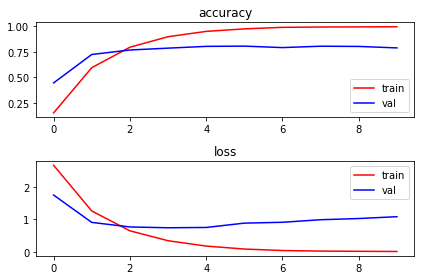

In [14]:
plt.subplot(211)
plt.title("accuracy")
plt.plot(history.history["acc"], color="r", label="train")
plt.plot(history.history["val_acc"], color="b", label="val")
plt.legend(loc="best")

plt.subplot(212)
plt.title("loss")
plt.plot(history.history["loss"], color="r", label="train")
plt.plot(history.history["val_loss"], color="b", label="val")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

## Evaluate Network

In [15]:
np.set_printoptions(linewidth=120)
Ytest_ = model.predict(Xtest)
ytest_ = np.argmax(Ytest_, axis=1)
ytest = np.argmax(Ytest, axis=1)
print("accuracy score: {:.3f}".format(accuracy_score(ytest, ytest_)))
print("\nconfusion matrix\n")
print(confusion_matrix(ytest, ytest_))

accuracy score: 0.820

confusion matrix

[[183   1   0   0   0   1   1   0   2   0   0   0   1   0   0   2   3   3   4  38]
 [  2 206  21  14   4  12  15   3   2   2   1   0   8   1   5   1   0   0   0   2]
 [  1  23 207  17   5   8   1   0   0   0   2   0   4   1   1   0   1   0   0   0]
 [  0  16  26 213  16   3  10   1   2   1   0   2   9   0   0   0   4   1   2   0]
 [  0   5   8  29 224   1  15   1   1   1   0   3   9   1   0   1   1   0   2   0]
 [  2  35  16   9   0 229   0   2   1   0   2   1   0   1   1   0   0   0   1   0]
 [  1   3   8   8  14   5 231   5   2   0   3   0   5   0   3   0   0   0   3   2]
 [  2   0   2   0   5   1   7 238   6   2   3   1   5   0   1   0   1   0   1   2]
 [  0   0   0   2   0   0   2   6 297   2   4   0   4   0   1   0   3   0   1   0]
 [  0   0   0   3   1   0   1   2   3 261  33   0   0   2   0   3   0   1   3   2]
 [  0   0   1   3   1   0   5   0   3   6 261   0   0   0   2   0   1   0   3   0]
 [  1   3   2   2   0   1   1   1   1   0   0 